In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns, math, os
from statsmodels. tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Обрабатываю данные
df = pd.read_csv('blockchain_dot_com_daily_data.csv')
#df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index('datetime', inplace=True)
#df2 = df.resample('M').mean()

# Данные имеют широкий диапазон значений применяю к ним логарифмирование и сдвиг по значению переменной и добавляю поля.
df['diff_usd'] = (df['market_price_usd'] / df['market_price_usd'].shift(1))
df['diff_hash'] = (df['hash_rate'] / df['hash_rate'].shift(1))
df['diff_log_usd'] = np.log(df['diff_usd']).diff()
df['diff_log_hash'] = np.log(df['diff_hash']).diff()

df['log_usd'] = np.log(df['market_price_usd'])#.diff()
df['log_hash'] = np.log(df['hash_rate'])#.diff()

# Данные хеш_рейта и цены биткоина доступны с 31.07.2015 по 02.09.2023, выбираю этот период.
df = df["2015-07-31":"2023-09-02"]
#df1 = df_log[['market_price_usd', 'hash_rate','log_usd', 'log_hash', 'diff_log_usd', 'diff_log_hash']]
df1 = df[['hash_rate','log_usd', 'log_hash']]

df1.head()

,hash_rate,log_usd,log_hash
datetime,,,
2015-07-31,361228.839522,5.664522,12.797267
2015-08-01,426198.055263,5.650065,12.962659
2015-08-02,408006.674856,5.638177,12.919039
2015-08-03,382018.988559,5.642829,12.853226
2015-08-04,374222.682670,5.638782,12.832606


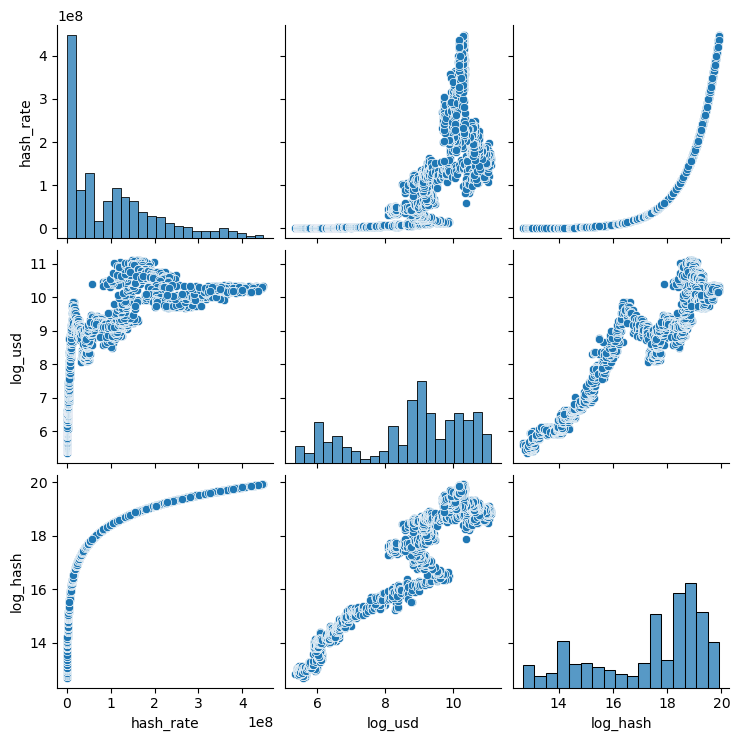

In [3]:
sns.pairplot(df1[['hash_rate', 'log_usd', 'log_hash']])

<Axes: xlabel='datetime'>

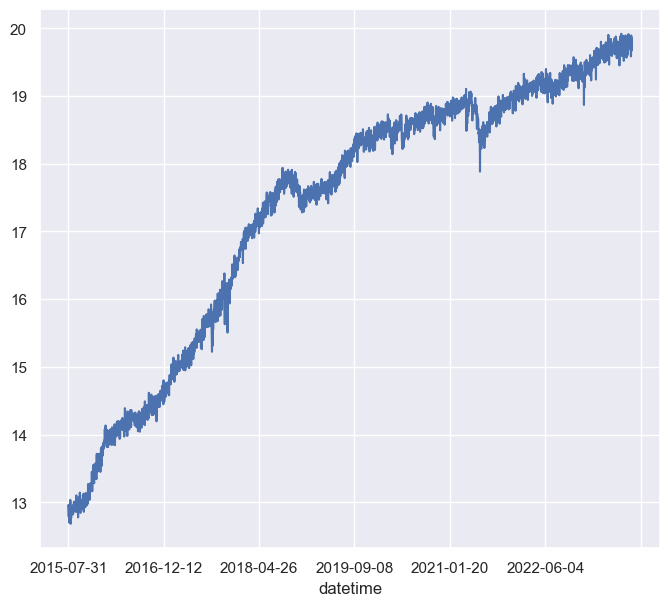

In [4]:
sns.set(rc={'figure.figsize':(8,7)})
df1['log_hash'].plot()

<Axes: >

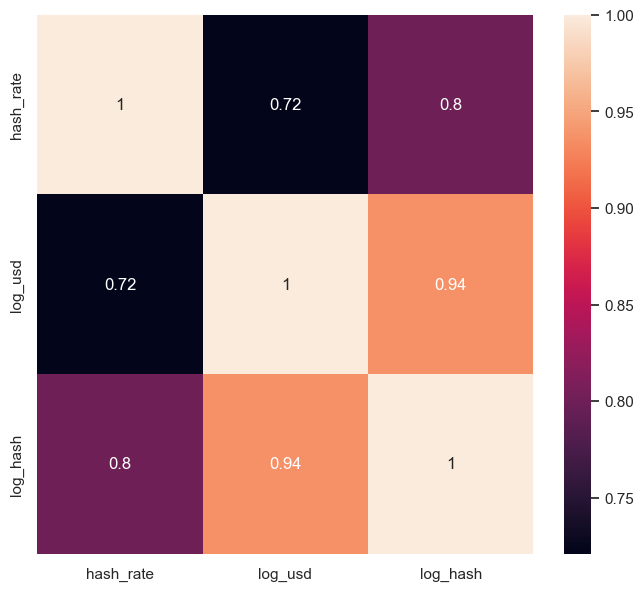

In [5]:
sns.set(rc={'figure.figsize':(8,7)})
sns.heatmap(df1.corr(), annot=True)

In [6]:
_usd = df1['log_usd'].tolist()
_hash = df1['log_hash'].tolist()

print(f"usd={adfuller(_usd)}")
print(f"hash ={adfuller(_hash)}")

usd=(-1.9548702590709333, 0.3067044954868434, 2, 2953, {'1%': -3.432566387909864, '5%': -2.862519254448958, '10%': -2.567291283859137}, -10766.13884468297)
hash =(-3.569411457674422, 0.006373473474572795, 14, 2941, {'1%': -3.4325754392267975, '5%': -2.862523252048813, '10%': -2.567293412144613}, -5363.064772594767)


In [7]:
data = df1[['log_usd', 'log_hash']]

In [8]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X = data.drop('log_usd', axis=1)
y = data['log_usd']

In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate decision tree model
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_y_pred)
dt_r2 = r2_score(y_test, dt_y_pred)

# Train and evaluate random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

# Train and evaluate gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
gb_y_pred = gb.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)

# Print the evaluation metrics
print("Decision Tree:")
print("MSE: ", dt_mse)
print("R^2: ", dt_r2)
print("\nRandom Forest:")
print("MSE: ", rf_mse)
print("R^2: ", rf_r2)
print("\nGradient Boosting:")
print("MSE: ", gb_mse)
print("R^2: ", gb_r2)

Decision Tree:
MSE:  0.18779691714960736
R^2:  0.9261976259759023

Random Forest:
MSE:  0.14436000294458373
R^2:  0.9432679135890794

Gradient Boosting:
MSE:  0.11650059587978927
R^2:  0.954216391399541


In [10]:
#from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import *

In [11]:
lag_order = select_order(data=data, maxlags=8, deterministic="ci")
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,-10.72,-10.71,2.204e-05,-10.72
1,-10.96,-10.93,1.740e-05,-10.95
2,-11.06,-11.02,1.579e-05,-11.04
3,-11.12,-11.08,1.483e-05,-11.10
4,-11.14,-11.09,1.452e-05,-11.12
5,-11.16,-11.10,1.429e-05,-11.14
6,-11.17,-11.10,1.414e-05,-11.14
7,-11.18,-11.10*,1.402e-05,-11.15
8,-11.18*,-11.10,1.396e-05*,-11.15*


In [12]:
lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic

(8, 7, 8, 8)

Чтобы увидеть более подробную информацию, мы можем использовать метод summary() CointRankResults. 

В каждой строке итоговой таблицы SimpleTable показан 

один тест с нулевой гипотезой 

«Ранг коинтеграции равен r_0» и

«Ранг коинтеграции больше r_0 и r_1». 
  
Последняя строка содержит информацию о выбранном ранге коинтеграции. Если его тестовая статистика меньше критического значения, используйте r_0 в качестве ранга коинтеграции. В противном случае используйте r_1.

In [13]:
rank_test = select_coint_rank(data, det_order=1, k_ar_diff=6, method="trace")
rank_test.rank

0

In [14]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,2,8.870,18.40


In [15]:
model = VECM(data, k_ar_diff=7, coint_rank=1)

In [16]:
vecm_res = model.fit()

In [17]:
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.log_usd,-0.0455,0.018,-2.472,0.013,-0.082,-0.009
L1.log_hash,0.0007,0.007,0.098,0.922,-0.014,0.015
L2.log_usd,0.0309,0.018,1.676,0.094,-0.005,0.067
L2.log_hash,0.0171,0.009,1.885,0.059,-0.001,0.035
L3.log_usd,0.0059,0.018,0.320,0.749,-0.030,0.042
L3.log_hash,0.0130,0.010,1.298,0.194,-0.007,0.033
L4.log_usd,0.0129,0.018,0.698,0.485,-0.023,0.049
L4.log_hash,0.0134,0.010,1.297,0.195,-0.007,0.034
L5.log_usd,0.0211,0.018,1.145,0.252,-0.015,0.057
L5.log_hash,0.0181,0.010,1.817,0.069,-0.001,0.038


Получение прогноза на ближайшие

периодов так же просто, как вызвать метод Predict(), передав в качестве аргумента шагов. 

Чтобы получить доверительные интервалы, мы также передаем желаемый уровень достоверности аргументу альфа.

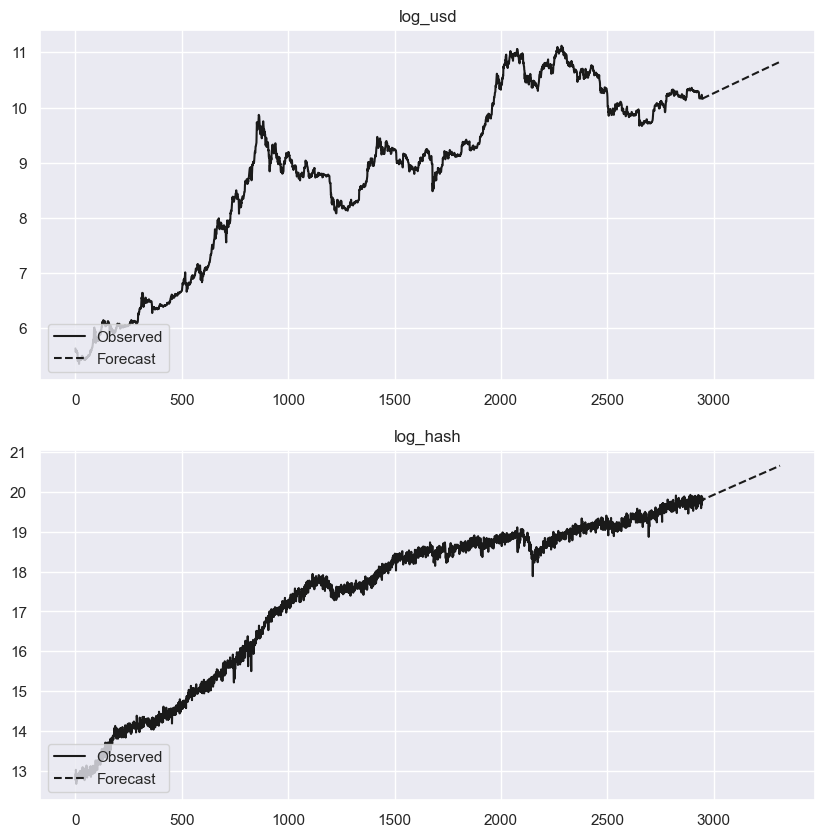

In [18]:
vecm_res.plot_forecast(steps=365, plot_conf_int=False)

Провожу тест Грейнджера-причинности. Тест Грейнджера причинности используется для проверки того, можно ли использовать один временной ряд для прогнозирования другого. 

Нулевая гипотеза (H0): временной ряд X не приводит к тому, что временной ряд Y становится причиной Грейнджера сам по себе.

In [19]:
granger_results = vecm_res.test_granger_causality(caused="log_usd", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
2.041,1.940,0.038,"(8, 5858)"


In [604]:
print(granger_results)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: log_hash does not Granger-cause log_usd: reject at 5% significance level. Test statistic: 2.041, critical value: 1.940>, p-value: 0.038>


Проведя F-тест Грейнджера на уровне значимости 5%, не удалось отвергнуть H_0 гипотезу о том, что временной ряд Хешрейта не приводит к тому, что временной ряд Цена(биткоина) становится причиной Грейнджера сам по себе.